Para esta atividade de aprendizado, utilizaremos um dataset que representa o churn de clientes de uma instituição bancária.

Iremos utilizar os conceitos de métodos **Ensemble** para treinamento de ML e **Explicabilidade de Modelos**. 

O que é Churn?

O Churn é um valor que representa a quantidade de clientes que deixaram de utilizar um determinado serviço.

Instalar as seguintes bibliotecas (caso não estejam instaladas):

```bash
pip install lime
pip install shap
pip install xgboost
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preparação de dados
from imblearn.under_sampling import RandomUnderSampler # Para lidar com classes desbalanceadas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Modelos preditivos
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Avaliação de modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Interpretabilidade de modelos
from lime import lime_tabular
import shap

Algumas funções uteis para facilitar a avaliação do modelo.

In [2]:
# Avaliando os modelos de classificação, calculando algumas métricas
def avaliar_modelo(y_true, y_pred, title):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(title)
    print(f'Acurácia: {accuracy*100:.2f}')
    print(f'Precisão: {precision*100:.2f}')
    print(f'Recall: {recall*100:.2f}')
    print(f'F1-Score: {f1*100:.2f}')

    #return accuracy, precision, recall, f1

# Plota a matriz de confusão 
def plotar_matriz_confusao(y_true, y_pred, title):
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot da matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Não Saiu', 'Saiu'], 
                yticklabels=['Não Saiu', 'Saiu'])
    plt.xlabel('Predição')
    plt.ylabel('Valor Real')
    plt.title(title)
    plt.show()

In [3]:
df = pd.read_csv('churn_modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
df.duplicated().sum() # Verificação de linhas duplicadas

np.int64(0)

**Visualização de gráficos *boxplot* para investigar se há presença de outliers.**

<Axes: >

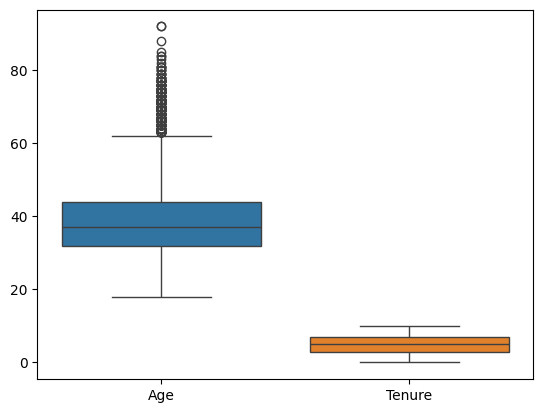

In [7]:
sns.boxplot(df[['Age', 'Tenure']])

<Axes: >

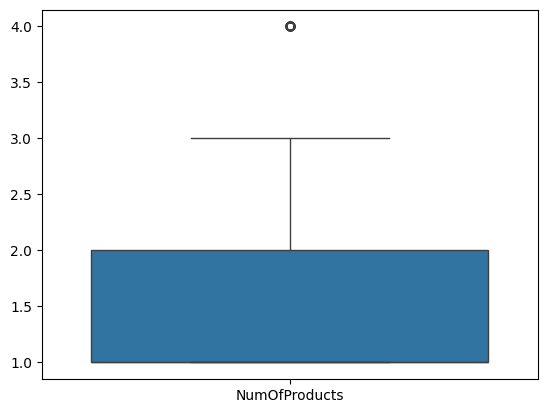

In [8]:
sns.boxplot(df[['NumOfProducts']])

<Axes: >

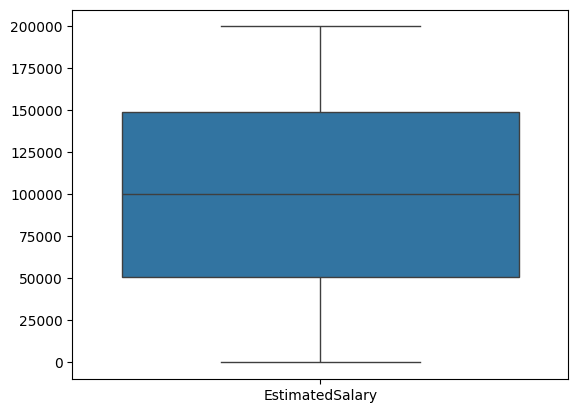

In [9]:
sns.boxplot(df[['EstimatedSalary']])

**Correlação das variáveis**

Text(0.5, 1.0, 'Matriz de Correlação')

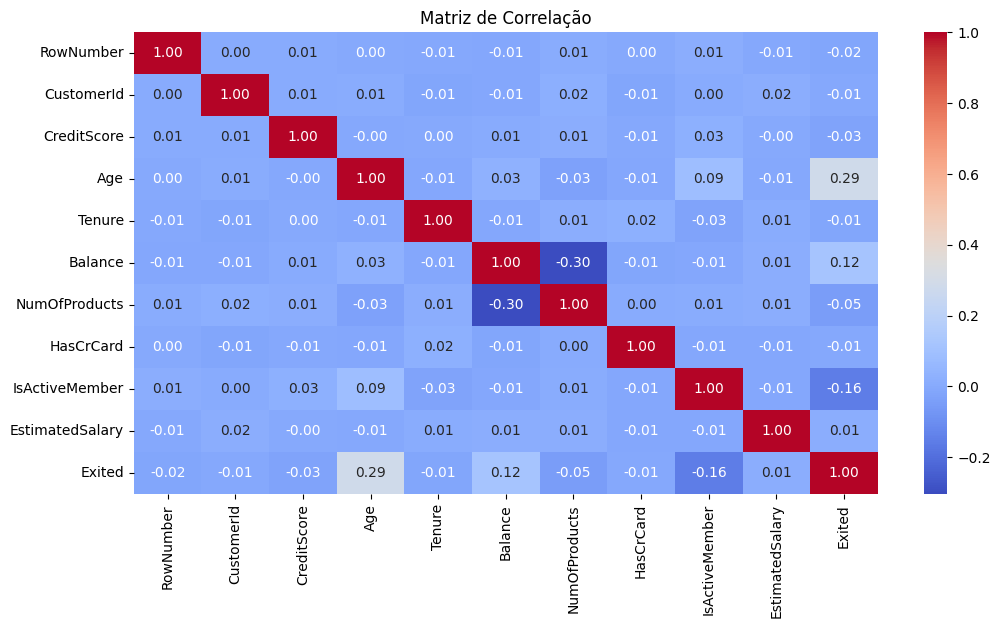

In [10]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True),
            annot=True,
            cmap='coolwarm',
            fmt='.2f') # Reduz a precisão dos números para apenas 2 casas depois da vírgula
plt.title("Matriz de Correlação")

**Remoção das variáveis sem relação com o problema**

In [11]:
# Eliminando linhas duplicadas
df.drop_duplicates(inplace=True)

df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

**Visualização o balanceamento das classes**

Text(0.5, 1.0, 'Distribuição da variável alvo Exited')

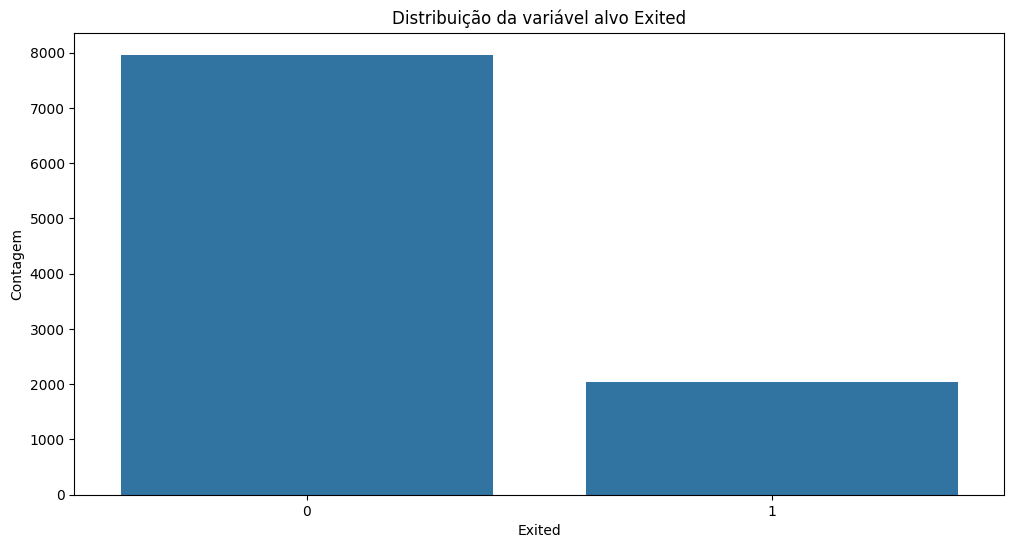

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='Exited', data=df)
plt.ylabel('Contagem')
plt.title("Distribuição da variável alvo Exited")

É possível observar no gráfico anterior que as classes não estão balanceadas, ou seja, há muitos exemplos de pessoas que não abandonaram os serviços (8k) em comparação com aqueles que abandonaram (~2k).

Portanto, para **diminuir o desbalanceamento** iremos remover 40% dos dados de "não churn" e manter todos os exemplos de "churn". Aqui não iremos eliminar o desbalanceamento por completo, apenas atenuá-lo.

In [13]:
# Separação das features do target
X = df.drop('Exited', axis=1)
y = df['Exited']

In [14]:
y.value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Iremos utilizar o *RandomUnderSampler* para reduzir o número de instâncias da classe majoritária para equilibrar as classes.

In [15]:
SEED = 80

value_to_remove = int(y.value_counts()[0] * 0.40) # Adquirindo 40% do total de amostras de "não churn"
rus = RandomUnderSampler(sampling_strategy={0:value_to_remove}, random_state=SEED)

In [16]:
# Aplicar o undersampling aos dados
X_resampled, y_resampled = rus.fit_resample(X, y)

# Criar um DataFrame com os dados reamostrados (irá juntar características com rótulos novamente)
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
df_resampled.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1022,547,France,Female,48,1,179380.74,2,0,1,69263.10,0
756,664,Germany,Female,36,2,127160.78,2,1,0,78140.75,0
6980,644,Germany,Female,34,10,122196.99,2,1,1,182099.71,0
4838,556,France,Female,40,9,129860.37,1,0,0,17992.94,0
2211,717,France,Male,40,0,98241.04,1,1,0,110887.14,0


Reduzimos o número de valores 0 (não churn) 40% do valor total anterior, agora temos ~3k de não churn e ~2k de churn.

<Axes: xlabel='Exited', ylabel='count'>

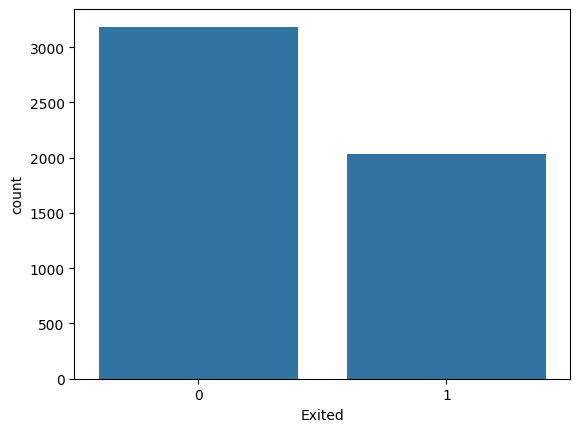

In [17]:
sns.countplot(x='Exited', data=df_resampled)

### Engenharia de features

Aplicando o OneHotEncoder para variáveis categóricas, separando treino e teste e padronizando as variáveis.

O parâmetro *drop_first* serve para evitar a multicolinearidade no modelo, em outras palavras, evita a redundância de variáveis.

In [18]:
# Converte variáveis categóricas para numéricas (se necessário)
df_resampled = pd.get_dummies(df_resampled, drop_first=True)
df_resampled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
1022,547,48,1,179380.74,2,0,1,69263.10,0,False,False,False
756,664,36,2,127160.78,2,1,0,78140.75,0,True,False,False
6980,644,34,10,122196.99,2,1,1,182099.71,0,True,False,False
4838,556,40,9,129860.37,1,0,0,17992.94,0,False,False,False
2211,717,40,0,98241.04,1,1,0,110887.14,0,False,False,True


In [19]:
# Separação das features do target
X = df_resampled.drop('Exited', axis=1)
y = df_resampled['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=SEED)

In [20]:
y_test.value_counts()

Exited
0    637
1    408
Name: count, dtype: int64

**Padronização das features numéricas**

In [21]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

### Criando um modelo baseline

Um modelo baseline basicamente serve para termos uma métrica base para levarmos em consideração ao treinar outros modelos mais complexos. No caso, serve para compararmos como o nosso modelo performa em relação a um modelo relativamente simples.

BASELINE
Acurácia: 71.77
Precisão: 69.02
Recall: 50.25
F1-Score: 58.16


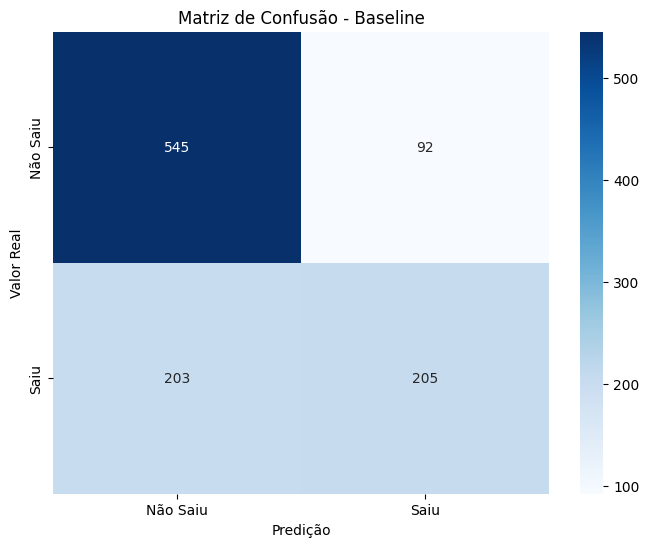

In [22]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_model.predict(X_test_scaled)
avaliar_modelo(y_test, y_pred_baseline, 'BASELINE')
plotar_matriz_confusao(y_test, y_pred_baseline, 'Matriz de Confusão - Baseline')

### Criando modelos Ensembles

Uma vez que temos um modelo baseline, podemos tentar criar modelos melhores, aplicando algoritmos mais complexos ou ensembles.

Iremos criar 1 modelo baseado em XGBoost e 4 ensembles distintos. Nossos modelos de base serão árvores de decisão, florestas aleatórias, KNN e SVM.

**BAGGING**

In [23]:
# Bagging - Combinação de 100 árvores independentes (simular à floresta aleatória)
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(),
                                  n_estimators=100,
                                  random_state=SEED)

bagging_model.fit(X_train_scaled, y_train)
y_pred_bagging = bagging_model.predict(X_test_scaled)

avaliar_modelo(y_test, y_pred_bagging, "BAGGING")

BAGGING
Acurácia: 77.03
Precisão: 72.58
Recall: 66.18
F1-Score: 69.23


In [24]:
boosting_model = AdaBoostClassifier(n_estimators=100,
                                  random_state=SEED)

boosting_model.fit(X_train_scaled, y_train)
y_pred_boosting = boosting_model.predict(X_test_scaled)

avaliar_modelo(y_test, y_pred_boosting, "BOOSTING")

c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


BOOSTING
Acurácia: 78.85
Precisão: 75.20
Recall: 68.38
F1-Score: 71.63


**Definindo ensembles (conjuntos) para VOTING e STACKING**

In [25]:
base_models = [
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rt', RandomForestClassifier(n_estimators=100, random_state=SEED)),
    ('knn', KNeighborsClassifier()),
    ('svc', SVC())
]

In [26]:
voting_model = VotingClassifier(estimators=base_models,
                                  voting='hard')

voting_model.fit(X_train_scaled, y_train)
y_pred_voting = voting_model.predict(X_test_scaled)

avaliar_modelo(y_test, y_pred_voting, "VOTING")

VOTING
Acurácia: 77.99
Precisão: 80.27
Recall: 57.84
F1-Score: 67.24


In [27]:
stacking_model = StackingClassifier(estimators=base_models,
                                  final_estimator=LogisticRegression())

stacking_model.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_model.predict(X_test_scaled)

avaliar_modelo(y_test, y_pred_stacking, "STACKING")

STACKING
Acurácia: 78.95
Precisão: 76.86
Recall: 65.93
F1-Score: 70.98


In [37]:
xgb_model = XGBClassifier(random_state=SEED)

xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

avaliar_modelo(y_test, y_pred_xgb, 'XGBoost')

XGBoost
Acurácia: 77.13
Precisão: 72.78
Recall: 66.18
F1-Score: 69.32


In [ ]:
# TODO: Interpretabilidade dos modelos